<a href="https://colab.research.google.com/github/stochasticats/plantpathologyfgvc7-keras-deeplearning/blob/master/plantpathologyfgvc7_keras_deeplearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import tensorflow as tf
print(tf.__version__)
from keras_preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import os
import shutil

1.15.0


# Load data and preprocessing
Here we load the data and process it so that it can be fed into the model. The data set is a zipped file located on my Google drive.

In [0]:
!unzip -uq "/content/drive/My Drive/plant-pathology-2020-fgvc7.zip"

In [0]:
dataset = pd.read_csv('train.csv')
print(dataset.head())
print(dataset.shape)

  image_id  healthy  multiple_diseases  rust  scab
0  Train_0        0                  0     0     1
1  Train_1        0                  1     0     0
2  Train_2        1                  0     0     0
3  Train_3        0                  0     1     0
4  Train_4        1                  0     0     0
(1821, 5)


In [0]:
dataset.describe()

,healthy,multiple_diseases,rust,scab
count,1821.000000,1821.000000,1821.000000,1821.000000
mean,0.283361,0.049973,0.341571,0.325096
std,0.450754,0.217948,0.474367,0.468539
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000


The data set is clearly imbalanced in one of the classes, that class being multiple_diseases. It's safe to say most of the plants are either healthy, scabby, or rusty. 

Now to split the data into train and validation sets, then take a quick look at their make up.

In [0]:
train, validation = train_test_split(dataset, test_size=0.2)

In [0]:
print(train.head())
print(validation.head())

        image_id  healthy  multiple_diseases  rust  scab
1265  Train_1265        1                  0     0     0
1695  Train_1695        0                  0     1     0
1132  Train_1132        0                  0     0     1
814    Train_814        0                  0     1     0
99      Train_99        1                  0     0     0
        image_id  healthy  multiple_diseases  rust  scab
757    Train_757        0                  0     0     1
1441  Train_1441        0                  0     1     0
1455  Train_1455        0                  0     1     0
1189  Train_1189        0                  0     1     0
852    Train_852        0                  0     1     0


In [0]:
print(train.describe())
print(validation.describe())

           healthy  multiple_diseases         rust         scab
count  1456.000000        1456.000000  1456.000000  1456.000000
mean      0.284341           0.046703     0.346841     0.322115
std       0.451255           0.211075     0.476128     0.467447
min       0.000000           0.000000     0.000000     0.000000
25%       0.000000           0.000000     0.000000     0.000000
50%       0.000000           0.000000     0.000000     0.000000
75%       1.000000           0.000000     1.000000     1.000000
max       1.000000           1.000000     1.000000     1.000000
          healthy  multiple_diseases        rust        scab
count  365.000000         365.000000  365.000000  365.000000
mean     0.279452           0.063014    0.320548    0.336986
std      0.449346           0.243321    0.467328    0.473329
min      0.000000           0.000000    0.000000    0.000000
25%      0.000000           0.000000    0.000000    0.000000
50%      0.000000           0.000000    0.000000    0.0000

Here I write code to put the images into a sorted directory based on their class so it is easier to use ImageDataGenerator.

In [0]:
ground_truth = train
folder = os.listdir('/content/unsorted_images')
train_list = list(ground_truth['image_id'])
base_dir = 'images'
os.mkdir(base_dir)
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
healthy = os.path.join(train_dir, 'healthy')
os.mkdir(healthy)
multiple_diseases = os.path.join(train_dir, 'multiple_diseases')
os.mkdir(multiple_diseases)
rust = os.path.join(train_dir, 'rust')
os.mkdir(rust)
scab = os.path.join(train_dir, 'scab')
os.mkdir(scab)
for row in ground_truth.iterrows():
    image = row[1].image_id
    label = row[1].index[row[1].values[1:].argmax() + 1]
    fname = image + '.jpg'
    if fname in folder:
       src = os.path.join('/content/unsorted_images', fname)
       dst = os.path.join(train_dir, label, fname)
       shutil.copyfile(src, dst)

In [0]:
ground_truth = validation
folder = os.listdir('/content/unsorted_images')
train_list = list(ground_truth['image_id'])
base_dir = 'valimages'
os.mkdir(base_dir)
train_dir = os.path.join(base_dir, 'validation')
os.mkdir(train_dir)
healthy = os.path.join(train_dir, 'healthy')
os.mkdir(healthy)
multiple_diseases = os.path.join(train_dir, 'multiple_diseases')
os.mkdir(multiple_diseases)
rust = os.path.join(train_dir, 'rust')
os.mkdir(rust)
scab = os.path.join(train_dir, 'scab')
os.mkdir(scab)
for row in ground_truth.iterrows():
    image = row[1].image_id
    label = row[1].index[row[1].values[1:].argmax() + 1]
    fname = image + '.jpg'
    if fname in folder:
       src = os.path.join('/content/unsorted_images', fname)
       dst = os.path.join(train_dir, label, fname)
       shutil.copyfile(src, dst)

Now lets process the image data using Keras

In [0]:
train_datagen = ImageDataGenerator(rescale = 1./255,
	    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
    directory = '/content/images/train',
    class_mode = 'categorical',
    target_size = (150,150),
    color_mode = 'rgb'
)

validation_generator = validation_datagen.flow_from_directory(
    directory = '/content/valimages/validation',
    class_mode = 'categorical',
    target_size = (150,150),
    color_mode = 'rgb'
)

Found 1456 images belonging to 4 classes.
Found 365 images belonging to 4 classes.


#Model Construction
Time to construct the model. This architecture was found using trial and error. I did not want to use a pre-trained model because where's the fun in that?

Since this is an image classification problem, most layers are 2D convolutions. The model performed better with no dense layers after the convolutions/before the softmax activation.

In [0]:
from keras import regularizers

model = tf.keras.models.Sequential([
    # This is the first convolution
    tf.keras.layers.Conv2D(32, (2,2), input_shape=(150, 150, 3)),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Conv2D(32, (2,2), kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3)),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Conv2D(64, (3,3), kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    # Third conv layer
    tf.keras.layers.Conv2D(128, (3,3)),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Conv2D(128, (3,3), kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    # Fourth conv layer
    tf.keras.layers.Conv2D(256, (5,5)),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Conv2D(256, (5,5), kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    # Flatten the results
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dropout(0.4),
    # 512 neuron hidden layer
    #tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 149, 149, 32)      416       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 148, 148, 32)      4128      
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 148, 148, 32)      0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 148, 148, 32)      128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 74, 74, 32)       

In [0]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

history = model.fit_generator(train_generator, epochs=50, validation_data = validation_generator, verbose=1)

Epoch 1/50
46/46 [==============================] - 73s 2s/step - loss: 2.1623 - acc: 0.3503 - val_loss: 1.8318 - val_acc: 0.3233
Epoch 2/50
46/46 [==============================] - 61s 1s/step - loss: 1.8929 - acc: 0.3764 - val_loss: 1.7045 - val_acc: 0.3370
Epoch 3/50
46/46 [==============================] - 61s 1s/step - loss: 1.6890 - acc: 0.4251 - val_loss: 1.7556 - val_acc: 0.3370
Epoch 4/50
46/46 [==============================] - 62s 1s/step - loss: 1.5409 - acc: 0.4931 - val_loss: 1.6534 - val_acc: 0.3370
Epoch 5/50
46/46 [==============================] - 61s 1s/step - loss: 1.3550 - acc: 0.5742 - val_loss: 1.7615 - val_acc: 0.3616
Epoch 6/50
46/46 [==============================] - 61s 1s/step - loss: 1.1261 - acc: 0.6532 - val_loss: 1.9499 - val_acc: 0.3205
Epoch 7/50
46/46 [==============================] - 62s 1s/step - loss: 1.0014 - acc: 0.7012 - val_loss: 1.7094 - val_acc: 0.4000
Epoch 8/50
46/46 [==============================] - 61s 1s/step - loss: 0.9707 - acc: 0.71

Plot of the model accuracy and loss of train and validation sets.

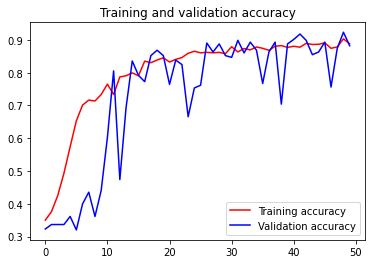

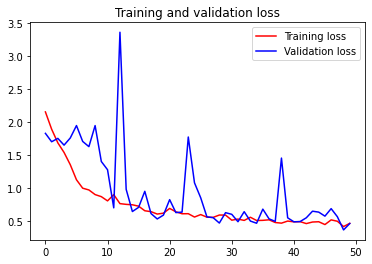

<Figure size 432x288 with 0 Axes>

In [0]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

In [0]:
model.save('plantmodel.h5')

In [0]:
from PIL import Image
from tqdm.notebook import tqdm
test = pd.read_csv('test.csv')
test_len = test.shape[0]
SIZE=150
PATH = '/content/drive/My Drive/testimages'
test_images = np.empty((test_len, SIZE, SIZE, 3))
for i in tqdm(range(test_len)):
    test_images[i] = np.uint8(Image.open(PATH + f'/Test_{i}.jpg').resize((SIZE, SIZE)))

In [0]:
probabilities = model.predict(test_images)

In [0]:
print(probabilities)

[[0.000000e+00 0.000000e+00 1.000000e+00 0.000000e+00]
 [0.000000e+00 0.000000e+00 1.000000e+00 0.000000e+00]
 [0.000000e+00 0.000000e+00 1.000000e+00 0.000000e+00]
 ...
 [0.000000e+00 0.000000e+00 1.000000e+00 0.000000e+00]
 [1.000000e+00 0.000000e+00 1.011384e-27 0.000000e+00]
 [0.000000e+00 0.000000e+00 1.000000e+00 0.000000e+00]]


In [0]:
type(probabilities)

numpy.ndarray

In [0]:
probs_df = pd.DataFrame(data=probabilities, columns=["healthy", "multiple_diseases", "rust", "scab"])

In [0]:
probs_df.head()

,healthy,multiple_diseases,rust,scab
0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0


In [0]:
submission = pd.concat([test['image_id'], probs_df], axis=1)

In [0]:
submission.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.0,0.0,1.0,0.0
1,Test_1,0.0,0.0,1.0,0.0
2,Test_2,0.0,0.0,1.0,0.0
3,Test_3,1.0,0.0,0.0,0.0
4,Test_4,0.0,0.0,1.0,0.0


In [0]:
submission.describe()

,healthy,multiple_diseases,rust,scab
count,1821.000000,1821.000000,1821.000000,1821.000000
mean,0.131248,0.091566,0.776674,0.000512
std,0.337368,0.288139,0.416066,0.021837
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000
75%,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,0.931880


In [0]:
submission.to_csv('submission.csv', index = False)